In [1]:
import pandas as pd

# Dados un lenguaje y el indice del dataset a usar (de 0 a 3)
# Abro un csv y lo devuelvo como DataFrame
def openDataset(lang, nameDataset):
    path_datasets = 'datasets/united/'
    
    pathfile = path_datasets + lang + '/' + nameDataset + 'Procesado2M-' + lang + '.csv'
    
    df = pd.read_csv(pathfile, delimiter='\t',encoding='UTF-16').dropna()
    df['emotion'] = df['emotion'].astype('int')
    
    print("Used dataset: " + pathfile)
    print("Size of data: " + str(len(df)))
    
    return df

In [2]:
#Dados un dataframe y un valor entre 0 y 1
# Divido el dataframe en 2 de acuerdo a la cantidad pasada por parametro
def splitDataframe(df, test_size):
    df.sort_values(by='text', axis=0, inplace=True, ignore_index=True)
    train_len = math.floor(len(df)*(1-test_size))
    df_train = df[:train_len]
    df_test = df[train_len:]
    print("Tamaño de set de entrenamiento: " + str(len(df_train)))
    print("Tamaño del set de testeo: " + str(len(df_test)))
    
    return df_train, df_test

In [3]:
def getEmotionsCount(df, model_index):
    emotions_count_p = [0,0,0,0,0,0,0,0,0] #Emociones de plutchick + no emo
    emotions_count_r = [0,0,0,0,0,0,0,0] #El 6 es trust+anticipation
    emotions_count_pnn = [0,0,0] #pos, neg, neu
    emotions_count_list = [emotions_count_p, emotions_count_r, emotions_count_pnn]

    #Cantidad de apariciones de emociones de Plutchick normales
    for e in df.emotion:
        emotions_count_p[e]+=1

    #Cantidad de apariciones de emociones comprimidas
    for e in df.newemotions:
        emotions_count_r[e]+=1

    #Cantidad de apariciones de emociones pos, neg y neu
    for e in df.posnegneu:
        emotions_count_pnn[e]+=1

    return emotions_count_list[model_index]

In [4]:
import math

#Calculo el promedio de apariciones de sentimientos para hacer el resampling
def getSamplesCount(emotions_count):
    sum_count = 0

    for i in range(len(emotions_count)):
        sum_count += emotions_count[i]
    samples = math.ceil(sum_count / len(emotions_count))
    return samples

In [5]:
from sklearn.utils import resample

#Dado un Dataframe, un entero que indica el modelo de emociones elegido y una cantidad de muestras
 #Realizo un upsample/downsample al Dataframe pasado por parametro y devuelvo un dataframe con el resampling realizado
def upsample(df, model_index, samples):
    #Separo las clases
     #Clases de Plutchick
    df_emo_0 = df[df.emotion==0]
    df_emo_1 = df[df.emotion==1]
    df_emo_2 = df[df.emotion==2]
    df_emo_3 = df[df.emotion==3]
    df_emo_4 = df[df.emotion==4]
    df_emo_5 = df[df.emotion==5]
    df_emo_6 = df[df.emotion==6]
    df_emo_7 = df[df.emotion==7]
    df_emo_8 = df[df.emotion==8]

    #Clases de Plutchick reducido
    df_emo_r_0 = df[df.newemotions==0]
    df_emo_r_1 = df[df.newemotions==1]
    df_emo_r_2 = df[df.newemotions==2]
    df_emo_r_3 = df[df.newemotions==3]
    df_emo_r_4 = df[df.newemotions==4]
    df_emo_r_5 = df[df.newemotions==5]
    df_emo_r_6 = df[df.newemotions==6]
    df_emo_r_7 = df[df.newemotions==7]

    #Clases de emociones posnegneu
    df_emo_pnn_0 = df[df.posnegneu==0]
    df_emo_pnn_1 = df[df.posnegneu==1]
    df_emo_pnn_2 = df[df.posnegneu==-1]

    list_df_emo = [df_emo_0, df_emo_1, df_emo_2, df_emo_3, df_emo_4,
                  df_emo_5, df_emo_6, df_emo_7, df_emo_8]
    list_df_emo_r = [df_emo_r_0, df_emo_r_1, df_emo_r_2, df_emo_r_3,
                    df_emo_r_4, df_emo_r_5, df_emo_r_6, df_emo_r_7]
    list_df_emo_pnn = [df_emo_pnn_0, df_emo_pnn_1, df_emo_pnn_2]
    list_lists_df_emo = [list_df_emo, list_df_emo_r, list_df_emo_pnn]

    #Resampleo el primer elemento de la lista
     #(asi puedo llamar a pd.concat en las ejecuciones sucesivas)
    df_minority_resampled = resample(list_lists_df_emo[model_index][0], 
                                         replace=True,     # sample with replacement
                                         n_samples=samples, # to match average class
                                         random_state=123) # reproducible results
    df_resampled = pd.concat([df_minority_resampled])

    # Upsample minority class
    for i in range(1,len(list_lists_df_emo[model_index])):
        df_minority_resampled = resample(list_lists_df_emo[model_index][i], 
                                         replace=True,     # sample with replacement
                                         n_samples=samples, # to match average class
                                         random_state=123) # reproducible results
        #Combino el resampling del resampleo de la emocion anterior con la actual
        df_resampled = pd.concat([df_resampled, df_minority_resampled])
    
    return df_resampled

In [6]:
#Dados dos dataframe y el indice, que indica el nombre de una columna
 #Separo el texto (X) y las emociones (y)
def getXandY(df_train, df_test, idx):
    list_emotions_columns = ['emotion', 'newemotions', 'posnegneu']
    column = list_emotions_columns[idx]
    
    X_train = df_train['text']
    Y_train = df_train[column]
    
    X_test = df_test['text']
    Y_test = df_test[column]
    
    return X_train, Y_train, X_test, Y_test

In [7]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
import numpy as np


def train(count_vect, tfidf_transformer, clf, X_train, Y_train):
    # Builds a dictionary of features and transforms documents to feature vectors and convert our text documents to a
    # matrix of token counts (CountVectorizer)
    X_train_counts = count_vect.fit_transform(X_train.values.astype('U'))
    # transform a count matrix to a normalized tf-idf representation (tf-idf transformer)
    X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
    clf.fit(X_train_tfidf, Y_train)

In [8]:
def test(count_vect, tfidf_transformer, clf, X_test, Y_test):
    docs_test = X_test
    X_test_counts = count_vect.transform(docs_test.values.astype('U'))
    #Ya fue adaptado el tfidf, no necesito el fit_transform
    X_test_tfidf = tfidf_transformer.transform(X_test_counts)
    predicted_test = clf.predict(X_test_tfidf)

    #Devuelvo la precision
    return np.mean(predicted_test == Y_test)*100, X_test_tfidf

In [9]:
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix

def drawMatrix(clf, X_test_tfidf, Y_test, lang, dataset_index, samples, list_emotions, name_model):
    pathfile = 'reports/models/'+name_model+'/'+lang+'/confusion_matrix-'+name_model+'-DS'+str(dataset_index)+'-'+lang+'-'+str(samples)+'.png'
    
    #Almaceno la matriz de confusion
    confusion_m = plot_confusion_matrix(clf, X_test_tfidf, Y_test, cmap=plt.cm.Blues, normalize=None, display_labels=list_emotions)
    
    plt.xticks(rotation='vertical')
    plt.savefig(pathfile)
    
    print("Saved file: " + pathfile)
    
    return confusion_m

In [10]:
#Guardo los datos con los cuales elabore el modelo y la precision
def saveModelData(lang, dataset_index, list_emotions, acc, samples, name_model):
    pathfile = 'reports/models/'+name_model+'/'+lang+'/model_data-'+name_model+'-DS'+str(dataset_index)+'-'+lang+'-'+str(samples)+'.txt'
    file = open(pathfile, 'w', encoding='utf-8')
    
    data =  "Datos sobre el modelo\n\n"
    data += "Lenguaje: " + lang + "\n"
    data += "Lista de emociones: " + str(list_emotions) + "\n"
    data += "Cantidad de muestras: " + str(samples) + "\n"
    data += "Precision del modelo: " + str(acc) + "%"
    
    file.write(data)
    file.close()
    print("Saved file: " + pathfile)

In [11]:
# CONFIGURATION VARIABLES

# Emotion taxonomy
dic_emotions_names = {'Plutchick':0, 'Plutchick reducido':1, 'Posnegneu':2}
list_emotions_names = ['plutchick', 'Plutchick reducido', 'Posnegneu']
model_index = 0
model = list_emotions_names[model_index]

# Language and related countries
dic_countries = {'en': ['alemania', 'arabia', 'australia', 'canada', 'china', 'corea del sur', 'francia', 
                        'india', 'indonesia', 'italia', 'japon', 'uk', 'rusia', 'sudafrica', 'turquia', 'eu', 'usa'],
                'es': ['argentina', 'mexico'],
                'pt':['brasil']}
lang = 'pt'

# Classifier
clf_names = ["MNB", "RF"]
clf_index = 1
clf_name = clf_names[clf_index]

# Dataset
names_dataset = ['datasetUnificado', 'datasetCrowdflower', 'datasetElectoral', 
                     'datasetEmoInt', 'datasetTec', 'datasetCF+EI+TEC']
dataset_index = 0
nameDataset = names_dataset[dataset_index]

#Defino las distintas listas de emociones
list_emotions_P = ['No emotion','Joy','Anger','Sadness','Disgust','Fear','Trust','Surprise','Anticipation']
list_emotions_P8 = ['No emotion','Joy','Anger','Sadness','Disgust','Fear','Trust+Anticipation','Surprise']
list_emotions_posnegneu = ['Neu','Pos','Neg']
list_emotions_labels = [list_emotions_P, list_emotions_P8, list_emotions_posnegneu]

In [12]:
df = openDataset(lang, nameDataset)
emotions_count = getEmotionsCount(df, model_index)
print(lang + ": " + str(emotions_count))

Used dataset: datasets/united/pt/datasetUnificadoProcesado2M-pt.csv
Size of data: 58661
pt: [12465, 15909, 3986, 9156, 1198, 11172, 234, 4447, 94]


plutchick
Used dataset: datasets/united/pt/datasetUnificadoProcesado2M-pt.csv
Size of data: 58661
Tamaño de set de entrenamiento: 46928
Tamaño del set de testeo: 11733
Muestras de cada emocion: 5215
Empieza el entrenamiento del RF
Finaliza el entrenamiento del RF
Precision del modelo: 35.77942555186227%
Saved file: reports/models/plutchick/pt/model_data-plutchick-DS0-pt-5215.txt
Saved file: reports/models/plutchick/pt/confusion_matrix-plutchick-DS0-pt-5215.png


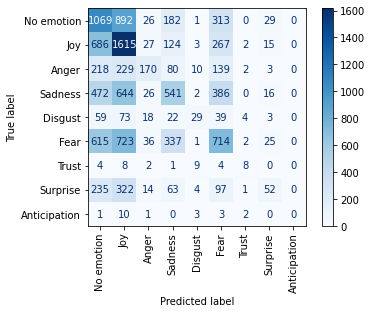

In [47]:
print(model)
df = openDataset(lang, nameDataset)
df_train, df_test = splitDataframe(df, 0.20)
emotions_count = getEmotionsCount(df_train, model_index)
samples_count = getSamplesCount(emotions_count)

upsample(df_train, model_index, samples_count)
print("Muestras de cada emocion: " + str(samples_count))

X_train, Y_train, X_test, Y_test = getXandY(df_train, df_test, model_index)

count_vect = CountVectorizer()
tfidf_transformer = TfidfTransformer()

if (clf_index == 0):
    clf = MultinomialNB()
else:
    clf = RandomForestClassifier(n_estimators = 100, criterion = 'entropy', random_state = 42)
print("Empieza el entrenamiento del " + clf_name)
train(count_vect, tfidf_transformer, clf, X_train, Y_train)
acc, X_test_tfidf = test(count_vect, tfidf_transformer, clf, X_test, Y_test)
print("Finaliza el entrenamiento del " + clf_name)
print("Precision del modelo: " + str(acc) + "%")
saveModelData(lang, dataset_index, list_emotions_labels[model_index], acc, samples_count, list_emotions_names[model_index])
drawMatrix(clf, X_test_tfidf, Y_test, lang, dataset_index, samples_count, list_emotions_labels[model_index], list_emotions_names[model_index])

Ahora que el modelo está entrenado y los datos a analizar procesados, ya es hora del análisis.

In [13]:
# TEMP
#Dado un filename, abro un archivo de la carpeta proc y devuelvo un Pandas dataframe
def readFileByPath(filepath):
    df = pd.read_csv(filepath, sep='\t', encoding='utf-8')
    
    print("Opened file: " + filepath)
    
    return df

In [14]:
#Dado un filename, abro un archivo de la carpeta proc y devuelvo un Pandas dataframe
def readFile(year, lang, filename):
    path_proc = 'results_processed/'+str(year)+'/'+lang+'/'
    df = pd.read_csv(path_proc+filename +'.csv', sep='\t', encoding='utf-8')
    
    return df

In [15]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

#Dado un dataframe con una coleccion de textos sin etiquetar, un count_vect, un transformer y un clf
    #devuelvo una (lista?) de etiquetas predichas
def predict_emotions(df, count_vect, tfidf_transformer, clf):
    docs_new = df['text'].values.astype('U')

    # building up feature vector of our input
    X_new_counts = count_vect.transform(docs_new)
    # We call transform instead of fit_transform because it's already been fit
    X_new_tfidf = tfidf_transformer.transform(X_new_counts)

    predicted_query = clf.predict(X_new_tfidf)
    return predicted_query

In [16]:
#A TENER EN CUENTA: Creo que lo mas elegante seria devolver un diccionario con las etiquetas de los sentimientos como claves
 #la comunicacion con daily_report seria mas clara
    
#Dada una lista de emociones predichas y una lista de etiquetas de sentimientos
 #retorno una lista de enteros, en el que se han contado la cantidad de apariciones de cada sentimiento
def count_emotions(list_emotions_predicted, list_emotions_labels):
    list_emotions_amount = list()
    
    #Inicializo la lista de cantidad de emociones
    for i in range(len(list_emotions_labels)):
        list_emotions_amount.append(int(0))
    
    #Cuento la cantidad de apariciones de cada sentimiento
    for i in range(len(list_emotions_predicted)):
        list_emotions_amount[list_emotions_predicted.iloc[i]] += 1
        
    return list_emotions_amount

In [17]:
#TENER EN CUENTA: los sentimientos pueden ser de plutchick, Plutchick reducido o POS NEG NEU

#Dado un dataframe con tweets y emociones predichas y una lista con las etiquetas de los sentimientos
 #devuelvo un dataframe que incluye una fecha y las apariciones totales de sentimientos en ese dia
def daily_report(df_tweets, list_emotions_labels):
    #Inicializo el diccionario
    dic_daily_report = {'created_at': list()}
    for emotion in list_emotions_labels:
        dic_daily_report[emotion] = list()
    
    #Ordeno el dataframe con tweets por fecha
    df_tweets['created_at'] = pd.to_datetime(df_tweets['created_at'], format='%a %b %d %H:%M:%S %z %Y')
    df_tweets_ordered = df_tweets.sort_values(by='created_at',ascending=True).reset_index().drop('index', axis=1)
    
    date = df_tweets_ordered['created_at'][0].date()
    ini_index_date = 0
    fin_index_date = 0
    
    index_last = len(df_tweets_ordered)
    
    for i in range(index_last):
        #Si me paso de fecha o llegue al ultimo elemento
        if(df_tweets_ordered['created_at'][i].date() != date or i==(index_last-1)):
            fin_index_date = i #Tomo las fechas desde ini hasta fin sin incluir
            #Proceso el sub_dataframe, que contiene todos los tweets de un mismo dia
            sub_df = df_tweets_ordered.iloc[ini_index_date:fin_index_date]#0:2
            
            #Agrego la fecha y las emociones contadas ese dia al diccionario
            dic_daily_report['created_at'].append(date)
            list_amount_emotions = count_emotions(sub_df['predicted'], list_emotions_labels)
            
            for j in range(len(list_emotions_labels)):
                dic_daily_report[list_emotions_labels[j]].append(list_amount_emotions[j])
            
            ini_index_date = i
            date = df_tweets_ordered['created_at'][i].date()
            
    df_daily_report = pd.DataFrame(dic_daily_report)
            
    return df_daily_report

In [18]:
import matplotlib
import matplotlib.pyplot as plt

#Dado un filename, un dataframe de tweets con una (lista?) de emociones predichas, una lista de etiquetas de emociones
#y un anio y un lenguaje
 #guardo las predicciones en un archivo
    #retorno un dataframe con el reporte
def save_predictions(filename, df_tweets, list_emotions_labels, year, lang, model):
    CANT_TWEETS = 30
    
    file = open('reports/models/'+model+'/'+lang+'/errors-'+lang+'-'+model+'.txt', 'a', encoding='utf-8')
    
    path_raw_tweets = 'results/'+str(year)+'/'+lang+'/'         # Donde guardo los tweets crudos de las consultas a ES
    path_predictions = 'predictions/'+model+'/'+str(year)+'/'+lang+'/'    # Donde guardare los csv con los reportes diarios
                                                                # de las predicciones de emociones
    df_daily_report = daily_report(df_tweets, list_emotions_labels)
    df_daily_report.to_csv(path_predictions+filename + '.csv', encoding='utf-8', index=False, sep='\t')

    ###
    #Creo el grafico
    ###
    if(not len(df_tweets)<CANT_TWEETS):

        labelsX = df_daily_report['created_at']
        labelsY = list(df_daily_report.columns.values[1:])
        width = 0.35

        fig, ax = plt.subplots()
        fig.set_figwidth(12)
        fig.set_figheight(9)
        plt.xticks(rotation='vertical')

        for i in range(len(labelsY)):
            ax.bar(labelsX, list(df_daily_report[labelsY[i]]), width, label=labelsY[i])
        ax.set_ylabel('Cantidad de apariciones')
        ax.set_ylabel('Fecha')
        ax.set_title('Apariciones de sentimientos')
        ax.legend()

        fig.savefig(path_predictions+filename + "- graphic_emotions.png", dpi=100)
        
        #plt.show()
        plt.close(fig) #Cierro la figura actual(de lo contrario todas las figuras se almacenan en memoria)
    else:
        file.write("Error: "+ filename +" tiene menos de "+str(CANT_TWEETS)+" tweets\n")    
    file.close()
    
    return df_daily_report

In [48]:
#Get predictions for all files with tweets
%load_ext jupyternotify

years = [2018, 2020, 2021]
countries = dic_countries[lang]
for year in years:
    for country in countries:
        for subject in range(0,4):
            print(str(year) + ' ' + country + ' ' + str(subject))
            name_file = country + ' ' + str(year) + ' - Tema ' + str(subject)
            df_tweets = readFile(year, lang, name_file)
            # Arabia 2020 no tiene tweets para ser transformados
            #corregir codigo para cuando no se tengan tweets
            if(len(df_tweets) > 0):
                predicted_emotions = predict_emotions(df_tweets, count_vect, tfidf_transformer, clf)
                df_tweets['predicted'] = predicted_emotions
                #Ver que hacer en caso de tener archivos con muy pocos tweets
                df_daily = save_predictions(name_file, df_tweets, list_emotions_labels[model_index], year, lang, model)
                df_tweets.to_csv("df_tweetsARG"+ str(subject) + ".csv", encoding="utf-8", sep="\t", index=False)
%notify

The jupyternotify extension is already loaded. To reload it, use:
  %reload_ext jupyternotify
2018 brasil 0
2018 brasil 1
2018 brasil 2
2018 brasil 3
2020 brasil 0
2020 brasil 1
2020 brasil 2
2020 brasil 3
2021 brasil 0
2021 brasil 1
2021 brasil 2
2021 brasil 3


<IPython.core.display.Javascript object>

In [40]:
path = 'toLabel\\new\\'+ lang + '\\'

In [41]:
#Get predictions for the labels made by us
%load_ext jupyternotify

new_predicted_emotions = list()

name_file = 'toLabel-common-' + lang +'.csv'
filepath = path  + name_file
df_tweets = readFileByPath(filepath)
if(len(df_tweets) > 0):
    predicted_emotions = predict_emotions(df_tweets, count_vect, tfidf_transformer, clf)
    for e in predicted_emotions:
        new_predicted_emotions.append(list_emotions_labels[model_index][e])
    df_tweets['Emotion'+lang.upper()+'-Machine'] = new_predicted_emotions
    filepath = path + model + '-DS' + str(dataset_index) +"-"+clf_name+"-all-predictions-" + lang + ".csv"
    df_tweets.to_csv(filepath, encoding="utf-8", sep="\t", index=False)
    print("Saved file: " + filepath)
%notify

The jupyternotify extension is already loaded. To reload it, use:
  %reload_ext jupyternotify
Opened file: toLabel\new\en\toLabel-common-en.csv
Saved file: toLabel\new\en\Plutchick-DS0-RF-all-predictions-en.csv


<IPython.core.display.Javascript object>

In [23]:
#Get predictions for all files with tweets
%load_ext jupyternotify

langs = ['es', 'en']
tweets = {'es':0, 'en':0}

for lang in langs:
    years = [2018, 2020, 2021]
    countries = dic_countries[lang]
    for year in years:
        for country in countries:
            for subject in range(0,4):
                print(str(year) + ' ' + country + ' ' + str(subject))
                name_file = country + ' ' + str(year) + ' - Tema ' + str(subject)
                df_tweets = readFile(year, lang, name_file)
                tweets[lang] += len(df_tweets)
%notify

The jupyternotify extension is already loaded. To reload it, use:
  %reload_ext jupyternotify
2018 argentina 0
2018 argentina 1
2018 argentina 2
2018 argentina 3
2018 mexico 0
2018 mexico 1
2018 mexico 2
2018 mexico 3
2020 argentina 0
2020 argentina 1
2020 argentina 2
2020 argentina 3
2020 mexico 0
2020 mexico 1
2020 mexico 2
2020 mexico 3
2021 argentina 0
2021 argentina 1
2021 argentina 2
2021 argentina 3
2021 mexico 0
2021 mexico 1
2021 mexico 2
2021 mexico 3
2018 alemania 0
2018 alemania 1
2018 alemania 2
2018 alemania 3
2018 arabia 0
2018 arabia 1
2018 arabia 2
2018 arabia 3
2018 australia 0
2018 australia 1
2018 australia 2
2018 australia 3
2018 canada 0
2018 canada 1
2018 canada 2
2018 canada 3
2018 china 0
2018 china 1
2018 china 2
2018 china 3
2018 corea del sur 0
2018 corea del sur 1
2018 corea del sur 2
2018 corea del sur 3
2018 francia 0
2018 francia 1
2018 francia 2
2018 francia 3
2018 india 0
2018 india 1
2018 india 2
2018 india 3
2018 indonesia 0
2018 indonesia 1
2018 ind

<IPython.core.display.Javascript object>

In [24]:
tweets

{'es': 81469, 'en': 730776}